# Visualización de Imagenes

### Conexion con drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Librerias

In [4]:
pip install pydicom matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 11.6 MB/s eta 0:00:00


In [5]:
pip install scikit-image

In [6]:
pip install scipy

In [7]:
pip install opencv-python

In [8]:
pip install pillow

In [9]:
pip install imageio

In [10]:
pip install pynrrd

In [11]:
pip install pandas

In [12]:
import os
import pydicom
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
import math
from scipy.ndimage import zoom
from scipy.ndimage import shift
import cv2
import nrrd
from collections import defaultdict
from tifffile import imsave
import pandas as pd

# Identificacion de los pacientes

### Organizacion y filtrado de los paths

In [13]:
def recorrer_directorios(root_dir):
    gk_paths = []
    for root, dirs, files in os.walk(root_dir):
        for dir in dirs:
            dir_path = os.path.join(root, dir)
            paths_MR = []
            paths_other = []
            for file in os.listdir(dir_path):
                file_path = os.path.join(dir_path, file)
                if 'dose' in file or 'target' in file:
                    continue  # No guardar los paths de los archivos con 'dose' o 'target' en su nombre
                elif 'MR' in file:
                    paths_MR.append(file_path)  # Guardar los paths de los archivos con 'MR' en su nombre
                else:
                    paths_other.append(file_path)  # Guardar los paths de los demás archivos
            gk_paths.append([paths_MR, paths_other])
    return gk_paths
root_dir = '/content/drive/MyDrive/Tesis/Data/GammaKnife/Brain-TR-GammaKnife-nrrd'
gk_paths = recorrer_directorios(root_dir)

df = pd.read_excel('/content/drive/MyDrive/Tesis/Data/GammaKnife/Brain-TR-GammaKnife_CI.xlsx',sheet_name='lesion_level_class')


In [ ]:
n_patient = 0
print('Path de la imagen ',n_patient,': ', gk_paths[n_patient][0])
print('Path de las segmentaciones:')
for n in range(len(gk_paths[n_patient][1])):
 print(gk_paths[n_patient][1][n])

Path de la imagen  0 :  ['/content/drive/MyDrive/Tesis/Data/GammaKnife/Brain-TR-GammaKnife-nrrd/GK.487_1/GK.487_1_MR_t1.nrrd']
Path de las segmentaciones:
/content/drive/MyDrive/Tesis/Data/GammaKnife/Brain-TR-GammaKnife-nrrd/GK.487_1/GK.487_1_LLt Parietal.nrrd
/content/drive/MyDrive/Tesis/Data/GammaKnife/Brain-TR-GammaKnife-nrrd/GK.487_1/GK.487_1_LRt Cerebellar.nrrd


# Carga de la imagen nrrd


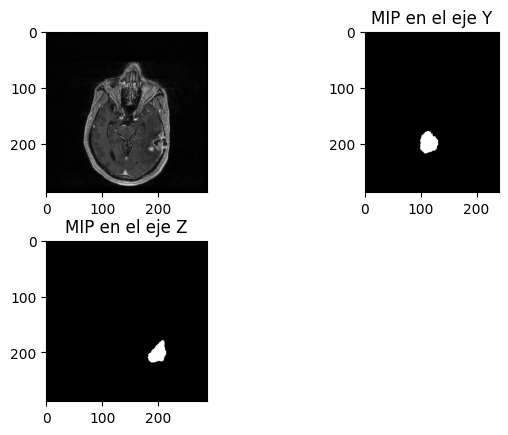

/content/drive/MyDrive/Tesis/Data/GammaKnife/Brain-TR-GammaKnife-nrrd/GK.487_1/GK.487_1_MR_t1.nrrd
/content/drive/MyDrive/Tesis/Data/GammaKnife/Brain-TR-GammaKnife-nrrd/GK.487_1/GK.487_1_LLt Parietal.nrrd
Size main: (288, 288, 240)
datos main OrderedDict([('type', 'int32'), ('dimension', 3), ('sizes', array([288, 288, 240])), ('endian', 'little'), ('encoding', 'gzip')])
Size segmentacion: (288, 288, 240)
datos seg <class 'collections.OrderedDict'>


In [16]:
# for n_patient in range(len(gk_paths[0])):
n_patient = 0
# Leer los datos del archivo
main_img_nrrd, header_main = nrrd.read(gk_paths[n_patient][0][0])
seg_img_nrrd, header_seg, = nrrd.read(gk_paths[n_patient][1][0])


mip_seg_nrrd_Z = np.max(seg_img_nrrd, axis=2)
mip_seg_nrrd_Y = np.max(seg_img_nrrd, axis=1)

# Seleccionar un slice en la tercera dimensión (cambiar el número según sea necesario)
slice_index = 116

# Crear una figura y un eje en matplotlib
plt.figure()
plt.subplots_adjust(wspace=0.6, hspace=0.3)
plt.subplot(2,2,1)
cax = plt.imshow(main_img_nrrd[:, :, slice_index], cmap=plt.cm.gray)

plt.subplot(2,2,2)
plt.imshow(mip_seg_nrrd_Y,cmap='gray')
plt.title('MIP en el eje Y')

plt.subplot(2,2,3)
plt.imshow(mip_seg_nrrd_Z,cmap='gray')
plt.title('MIP en el eje Z')
#cax = plt.imshow(seg_img_nrrd[:, :, slice_index], cmap=plt.cm.gray)
plt.show()

print(gk_paths[n_patient][0][0])
print(gk_paths[n_patient][1][0])

print('Size main:',seg_img_nrrd.shape)
print('datos main',header_seg)

print('Size segmentacion:',seg_img_nrrd.shape)
print('datos seg',type(header_seg))



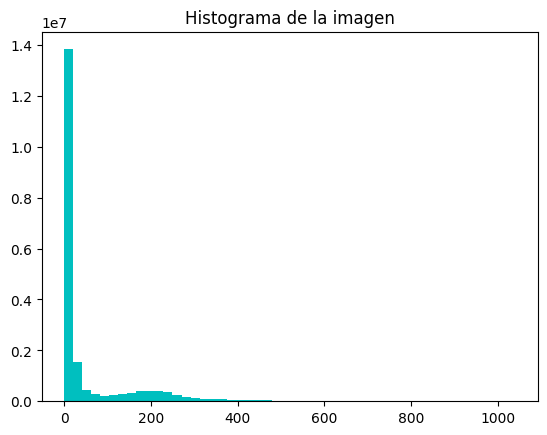

El valor máximo en la imagen es 1040


In [17]:
# Supongamos que 'main_img_nrrd' es tu imagen 3D
# main_img_nrrd = ...

# Aplanar la imagen 3D en 1D para el histograma
img_flattened = main_img_nrrd.flatten()

# Crear el histograma
plt.hist(img_flattened, bins=50, color='c')
plt.title("Histograma de la imagen")
plt.show()

# Encontrar y mostrar el valor máximo
max_value = np.max(main_img_nrrd)
print(f"El valor máximo en la imagen es {max_value}")


## Aplicación de la máscara





### Funcion mask_app_nrrd()

In [18]:
# Solo para propositos de visualizacion, no afecta al flujo de procesamiento

def mask_app_nrrd(main_img, seg_mask, n_slice):
    # Seleccionar una rebanada específica
    main_img_slice = main_img[:, :, n_slice]
    seg_mask_slice = seg_mask[:, :, n_slice]

    # Normalizar las imágenes al rango 0-255 si no lo están
    main_img_slice = cv2.normalize(main_img_slice, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    seg_mask_slice = cv2.normalize(seg_mask_slice, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    # Convertir las imágenes a RGB
    main_img_rgb = cv2.cvtColor(main_img_slice, cv2.COLOR_GRAY2BGR)
    seg_mask_rgb = cv2.cvtColor(seg_mask_slice, cv2.COLOR_GRAY2BGR)

    # Crear una imagen en color rojo con la máscara
    img_red = np.zeros_like(seg_mask_rgb)
    img_red[:, :, 0] = seg_mask_rgb[:, :, 0]  # Canal rojo

    # Superponer la imagen roja sobre main_img con un 50% de transparencia
    main_mask = cv2.addWeighted(main_img_rgb, 0.5, img_red, 0.5, 0)

    return main_mask


### Aplicacion de la mascara y ploteo

Slice N°: 116


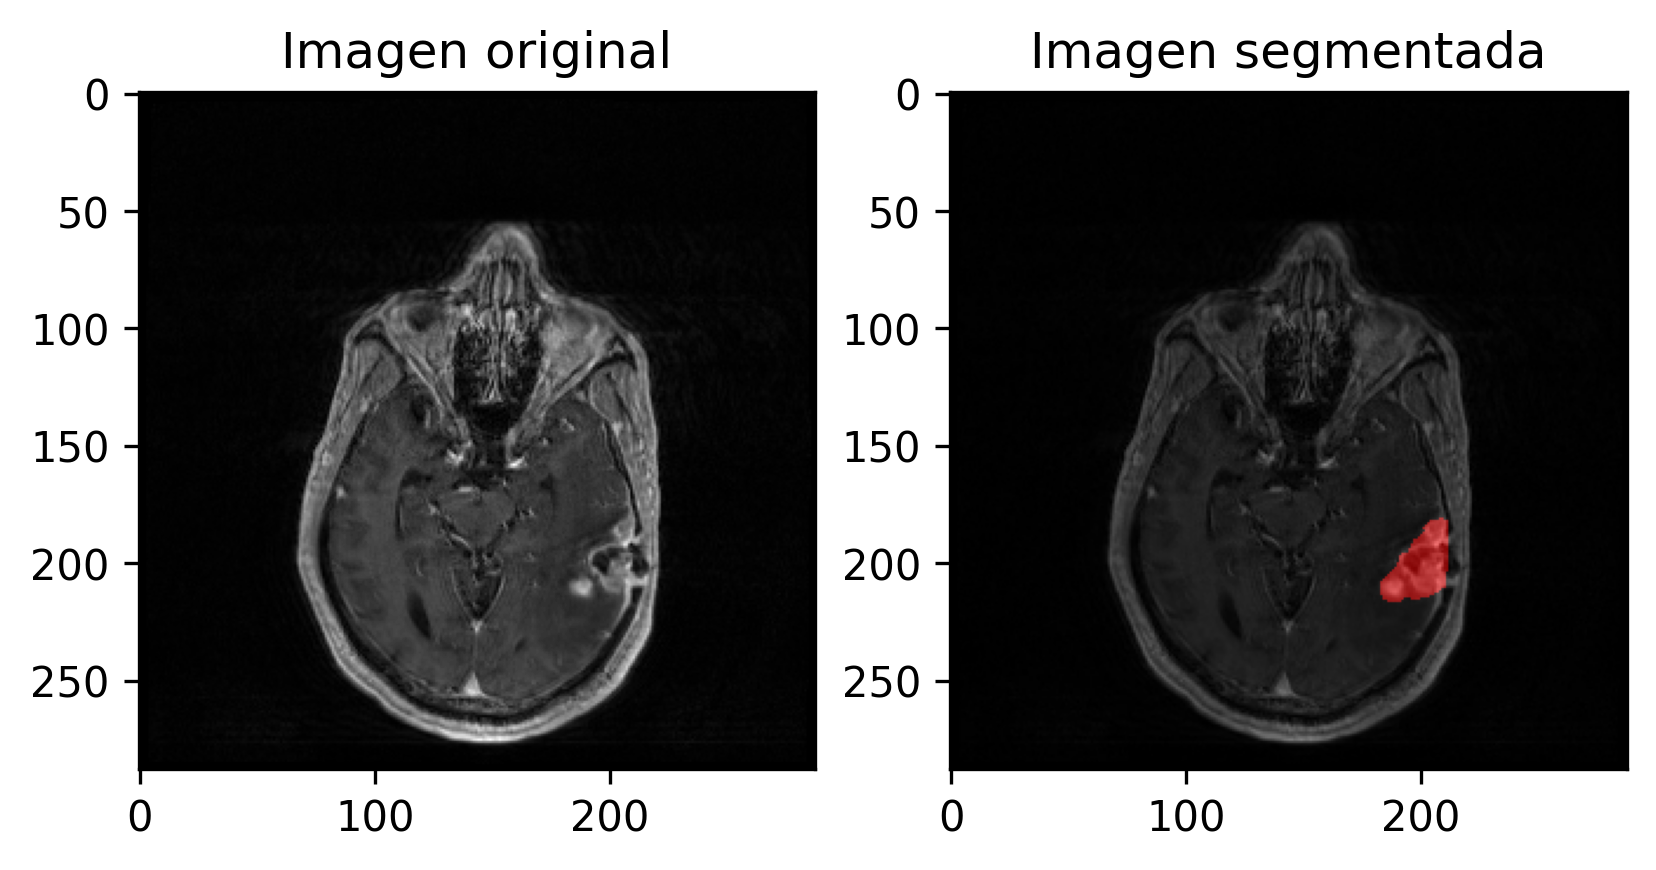

In [19]:

n_slice = slice_index
main_mask=mask_app_nrrd(main_img_nrrd, seg_img_nrrd,n_slice)

# Mostrar la imagen final
print('Slice N°:', n_slice)
plt.figure(dpi=300)
plt.subplot(1,2,1)
plt.imshow(main_img_nrrd[:, :, n_slice],cmap='gray')
plt.title('Imagen original')

plt.subplot(1,2,2)
plt.imshow(main_mask,cmap='gray')
plt.title('Imagen segmentada')
plt.show()

# Resize de la máscara y la imagen principal

### Funcion crop_square()

In [20]:
import numpy as np
import cv2

import numpy as np
from scipy.ndimage import zoom

def crop_square(imagen):
    # Obtener las dimensiones de la imagen original
    dim_x, dim_y, dim_z = imagen.shape

    # Calcular la dimensión máxima
    max_dim = max(dim_x, dim_y, dim_z)

    # Calcular cuántos ceros necesitas añadir para hacer la imagen cúbica
    padding_x = max_dim - dim_x
    padding_y = max_dim - dim_y
    padding_z = max_dim - dim_z

    # Calcular cuántos ceros necesitas añadir a cada lado para cada dimensión
    padding_x_before, padding_x_after = padding_x // 2, padding_x // 2
    padding_y_before, padding_y_after = padding_y // 2, padding_y // 2
    padding_z_before, padding_z_after = padding_z // 2, padding_z // 2

    # Añadir los ceros a la imagen para obtener una imagen cúbica
    imagen_cubica = np.pad(imagen, ((padding_x_before, padding_x_after),
                                     (padding_y_before, padding_y_after),
                                     (padding_z_before, padding_z_after)))

    # Si la imagen cúbica es más grande que 256 en cualquier dimensión, redimensionarla a 256x256x256
    if max_dim > 256:
        scale = 256.0 / max_dim
        imagen_cubica = zoom(imagen_cubica, (scale, scale, scale))

    return imagen_cubica


### Aplicacion de la máscara

Slice N°: 108


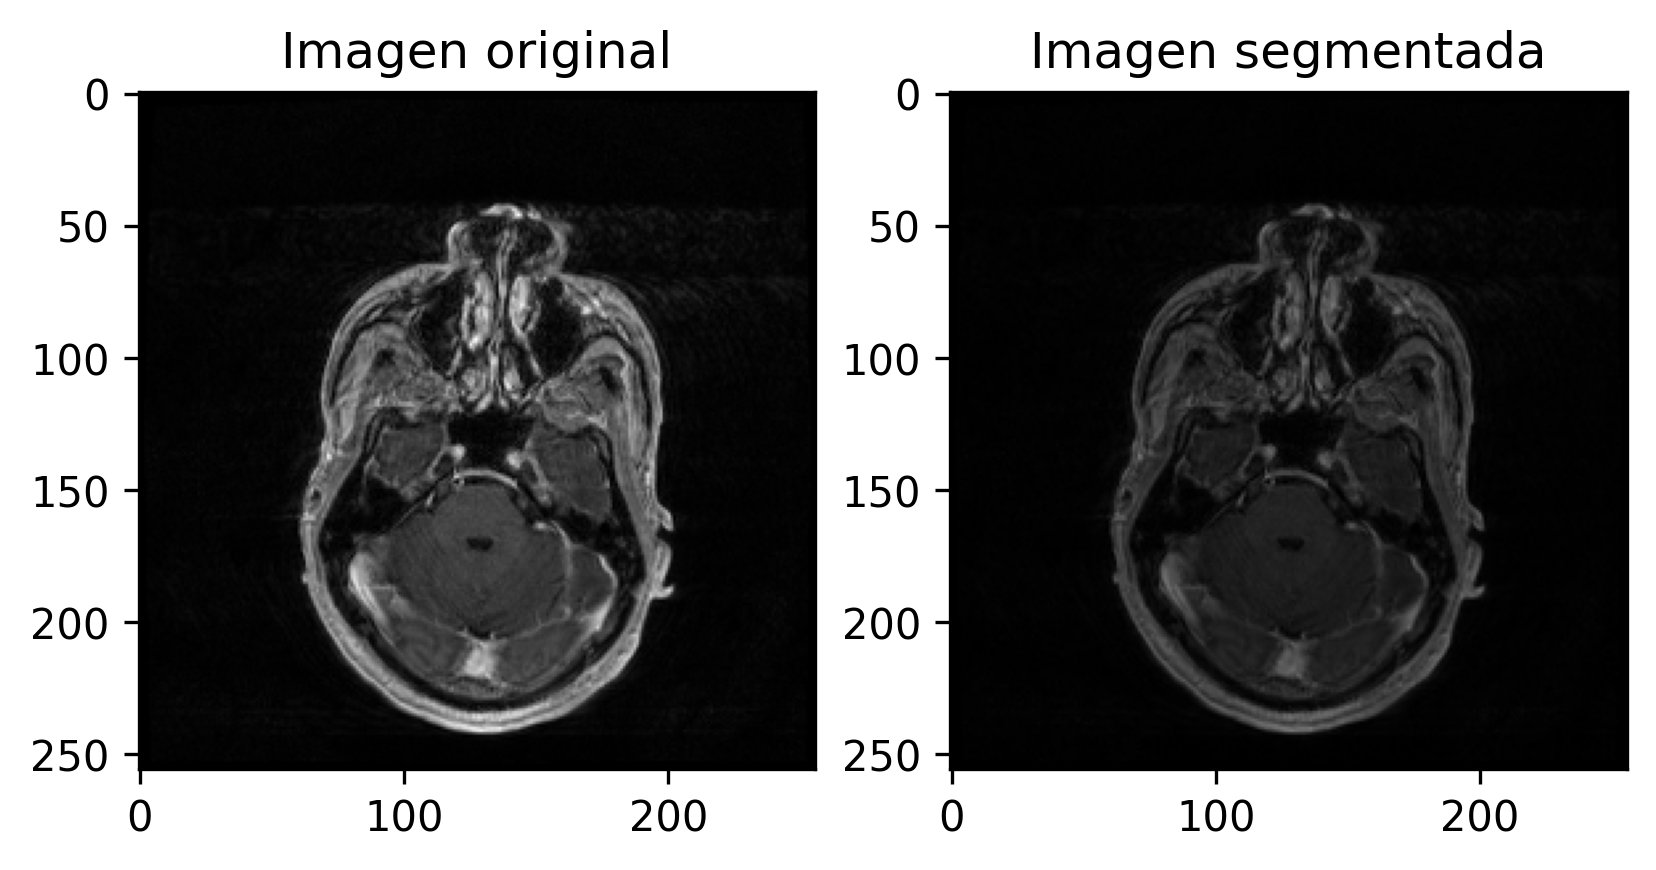

Slice N°: 108
Las antiguas dimensiones son: (288, 288, 240)
Las nuevas dimensiones son: (256, 256, 256)


In [22]:
main_crop = crop_square(main_img_nrrd)
mask_crop = crop_square(seg_img_nrrd)

n_slice = round(slice_index + (main_crop.shape[0]-main_img_nrrd.shape[0])/2)

# Superponer la imagen roja sobre main_img con un 50% de transparencia usando mask_app
lag = int((main_crop.shape[2]-main_img_nrrd.shape[2])/2)

main_crop_mask = mask_app_nrrd(main_crop,mask_crop, n_slice+lag)

# Mostrar la imagen final
print('Slice N°:', n_slice+lag)

# Plotting
plt.figure(dpi=300)
plt.subplot(1,2,1)
plt.imshow(main_crop[:,:,n_slice+lag],cmap='gray')
plt.title('Imagen original')

plt.subplot(1,2,2)
plt.imshow(main_crop_mask, cmap='gray')
plt.title('Imagen segmentada')
plt.show()

print('Slice N°:',n_slice+lag)
print('Las antiguas dimensiones son:',main_img_nrrd.shape)
print('Las nuevas dimensiones son:',mask_crop.shape)

# Lectura del xlsx

In [ ]:
nombre_archivo = os.path.splitext(os.path.basename(gk_paths[n_patient][1][0]))[0]
if nombre_archivo in df['Lesion Name in NRRD files'].values:
  localizacion = df[(df['Lesion Name in NRRD files']==nombre_archivo)]['Location'].item()

print(nombre_archivo)
print('Loc:',localizacion)


GK.487_1_LLt Parietal
Loc: Parietal Lobe


# Bucle

/content/drive/MyDrive/Tesis/Data/GammaKnife/Brain-TR-GammaKnife-nrrd/GK.467_1/GK.467_1_MR_t1.nrrd
Path: /content/drive/MyDrive/Tesis/Data/GammaKnife/Brain-TR-GammaKnife-nrrd/GK.467_1/GK.467_1_LRt Frontal.nrrd
Localizacion: Frontal Lobe
Path: /content/drive/MyDrive/Tesis/Data/GammaKnife/Brain-TR-GammaKnife-nrrd/GK.467_1/GK.467_1_LLt post paramedian.nrrd
Localizacion: Other
Path: /content/drive/MyDrive/Tesis/Data/GammaKnife/Brain-TR-GammaKnife-nrrd/GK.467_1/GK.467_1_LRt Ant Temporal.nrrd
Localizacion: Temporal Lobe
Path: /content/drive/MyDrive/Tesis/Data/GammaKnife/Brain-TR-GammaKnife-nrrd/GK.467_1/GK.467_1_LRt Inf Occipital.nrrd
Localizacion: Other
Path: /content/drive/MyDrive/Tesis/Data/GammaKnife/Brain-TR-GammaKnife-nrrd/GK.467_1/GK.467_1_LLt Ant Temporal.nrrd
Localizacion: Other
Path: /content/drive/MyDrive/Tesis/Data/GammaKnife/Brain-TR-GammaKnife-nrrd/GK.467_1/GK.467_1_LRt Occipital.nrrd
Localizacion: Occipital Lobe
Path: /content/drive/MyDrive/Tesis/Data/GammaKnife/Brain-TR-Gamma

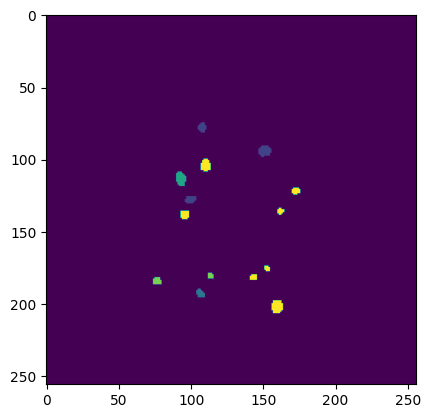

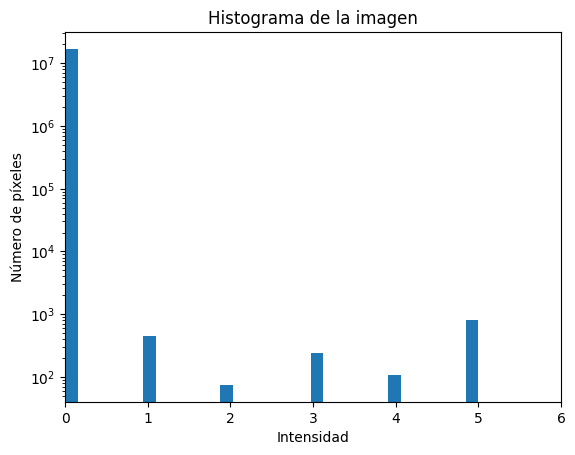

In [ ]:
# for n_patient in range(len(gk_paths[0])):
seg_img_nrrd = []
main_img_nrrd = []
final_mask = np.zeros((256, 256, 256))
n_patient = 4
print(gk_paths[n_patient][0][0])

main_img_nrrd, header_main = nrrd.read(gk_paths[n_patient][0][0])
main_crop = crop_square(main_img_nrrd)

for i in range(len(gk_paths[n_patient][1])):
  # Leer los datos del archivo
  seg_img_nrrd, header_seg, = nrrd.read(gk_paths[n_patient][1][i])
  mask_crop = crop_square(seg_img_nrrd)

  # Matching con los nombres
  nombre_archivo = os.path.splitext(os.path.basename(gk_paths[n_patient][1][i]))[0]
  if nombre_archivo in df['Lesion Name in NRRD files'].values:
    localizacion = df[(df['Lesion Name in NRRD files']==nombre_archivo)]['Location'].item()
  print('Path:',gk_paths[n_patient][1][i])
  print('Localizacion:',localizacion)

  # Clasificacion
  # Supongamos que 'localizacion' es la variable que contiene la localización,
  # y 'final_mask' y 'mask_crop' son tus matrices

  if localizacion == 'Frontal Lobe':
    final_mask = final_mask + mask_crop*1
  elif localizacion == 'Occipital Lobe':
    final_mask = final_mask + mask_crop*2
  elif localizacion == 'Temporal Lobe':
    final_mask = final_mask + mask_crop*3
  elif localizacion == 'Parietal Lobe':
    final_mask = final_mask + mask_crop*4
  else:
    final_mask = final_mask + mask_crop*5


mip_final_mask_Z = np.max(final_mask, axis =2)
plt.figure()
plt.imshow(mip_final_mask_Z)
plt.show()

plt.figure()
# Calcular el histograma
histograma = plt.hist(final_mask[:,:,:].ravel(), bins=32)

# Mostrar el histograma
plt.yscale('log')
plt.xlim(0,6)
plt.title("Histograma de la imagen")
plt.xlabel("Intensidad")
plt.ylabel("Número de píxeles")
plt.show()

## Guardar las imagenes

In [ ]:
# Asumiendo que 'array' es tu numpy array de 3 dimensiones
# Ejemplo de un array 3D

# Especifica la ruta donde quieres guardar el archivo .tif
path_main_crop = '/content/drive/MyDrive/Tesis/Data/GK_Unet/train_img.tiff'

# Guardar el array como un archivo .tif
imsave(path_main_crop, main_crop)

path_mask_crop = '/content/drive/MyDrive/Tesis/Data/GK_Unet/train_mask.tiff'
imsave(path_mask_crop, final_mask)

<ipython-input-135-47f8d474521c>:8: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  imsave(path_main_crop, main_crop)
<ipython-input-135-47f8d474521c>:11: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  imsave(path_mask_crop, final_mask)


# All

### Clasificacion

In [ ]:
new_root = '/content/drive/MyDrive/Tesis/Project/GK_Unet/'
for n_patient in range(len(gk_paths)):
  # Nombre ---------------------------------------------------------------------
  file_name_main = os.path.splitext(os.path.basename(gk_paths[n_patient][0][0]))[0]
  new_filename_main = f"{file_name_main[:8]}_train_img.tiff" # se recuperan los 8 primeros caracteres y se concatenan a _train_img.tiff
  new_filename_seg = f"{file_name_main[:8]}_train_mask.tiff"

  path_main_train = os.path.join(new_root,'Img/', new_filename_main) # se concatena para conseguir el path final
  path_seg_train = os.path.join(new_root,'Mask/', new_filename_seg)

  seg_img_nrrd = []
  main_img_nrrd = []
  final_mask = np.zeros((256, 256, 256))
  print('Numero de paciente:', n_patient)
  print(gk_paths[n_patient][0][0])

  main_img_nrrd, header_main = nrrd.read(gk_paths[n_patient][0][0])
  main_crop = crop_square(main_img_nrrd)

  for i in range(len(gk_paths[n_patient][1])):
    # Leer los datos del archivo
    seg_img_nrrd, header_seg, = nrrd.read(gk_paths[n_patient][1][i])
    mask_crop = crop_square(seg_img_nrrd)

    # Matching con los nombres
    nombre_archivo = os.path.splitext(os.path.basename(gk_paths[n_patient][1][i]))[0]
    if nombre_archivo in df['Lesion Name in NRRD files'].values:
      localizacion = df[(df['Lesion Name in NRRD files']==nombre_archivo)]['Location'].item()
    print('Path:',gk_paths[n_patient][1][i])
    print('Localizacion:',localizacion)

    # Clasificacion
    # Supongamos que 'localizacion' es la variable que contiene la localización,
    # y 'final_mask' y 'mask_crop' son tus matrices

    if localizacion == 'Frontal Lobe':
      final_mask = final_mask + mask_crop*1
    elif localizacion == 'Occipital Lobe':
      final_mask = final_mask + mask_crop*2
    elif localizacion == 'Temporal Lobe':
      final_mask = final_mask + mask_crop*3
    elif localizacion == 'Parietal Lobe':
      final_mask = final_mask + mask_crop*4
    else:
      final_mask = final_mask + mask_crop*5

  mip_final_mask_Z = np.max(final_mask, axis =2)
  plt.figure()
  plt.imshow(mip_final_mask_Z)
  plt.show()

  plt.figure()
  # Calcular el histograma
  histograma = plt.hist(final_mask[:,:,:].ravel(), bins=32)

  # Mostrar el histograma
  plt.yscale('log')
  plt.xlim(0,6)
  plt.title("Histograma de la imagen")
  plt.xlabel("Intensidad")
  plt.ylabel("Número de píxeles")
  plt.show()
  main_crop = np.uint8(main_crop)
  final_mask = np.uint8(final_mask)

  imsave(path_main_train, main_crop) #Se guarda la imagen
  imsave(path_seg_train, final_mask)


Output hidden; open in https://colab.research.google.com to view.

### Bin

In [ ]:
new_root = '/content/drive/MyDrive/Tesis/Project/GK_Unet/'
for n_patient in range(len(gk_paths)):
  # Nombre ---------------------------------------------------------------------
  file_name_main = os.path.splitext(os.path.basename(gk_paths[n_patient][0][0]))[0]
  new_filename_main = f"{file_name_main[:8]}_train_img.tiff" # se recuperan los 8 primeros caracteres y se concatenan a _train_img.tiff
  new_filename_seg = f"{file_name_main[:8]}_train_mask.tiff"

  path_main_train = os.path.join(new_root,'Img/', new_filename_main) # se concatena para conseguir el path final
  path_seg_train = os.path.join(new_root,'Maskbin/', new_filename_seg)

  seg_img_nrrd = []
  main_img_nrrd = []
  final_mask = np.zeros((256, 256, 256))
  print('Numero de paciente:', n_patient)
  print(gk_paths[n_patient][0][0])

  main_img_nrrd, header_main = nrrd.read(gk_paths[n_patient][0][0])
  main_crop = crop_square(main_img_nrrd)

  for i in range(len(gk_paths[n_patient][1])):
    # Leer los datos del archivo
    seg_img_nrrd, header_seg, = nrrd.read(gk_paths[n_patient][1][i])
    mask_crop = crop_square(seg_img_nrrd)

    # Matching con los nombres
    #nombre_archivo = os.path.splitext(os.path.basename(gk_paths[n_patient][1][i]))[0]
    #if nombre_archivo in df['Lesion Name in NRRD files'].values:
    #  localizacion = df[(df['Lesion Name in NRRD files']==nombre_archivo)]['Location'].item()
    #print('Path:',gk_paths[n_patient][1][i])
    #print('Localizacion:',localizacion)

    # Clasificacion
    # Supongamos que 'localizacion' es la variable que contiene la localización,
    # y 'final_mask' y 'mask_crop' son tus matrices

    #if localizacion == 'Frontal Lobe':
    #  final_mask = final_mask + mask_crop*1
    #elif localizacion == 'Occipital Lobe':
    #  final_mask = final_mask + mask_crop*2
    #elif localizacion == 'Temporal Lobe':
    #  final_mask = final_mask + mask_crop*3
    #elif localizacion == 'Parietal Lobe':
    #  final_mask = final_mask + mask_crop*4
    #else:
    final_mask = final_mask + mask_crop

  mip_final_mask_Z = np.max(final_mask, axis =2)
  plt.figure()
  plt.imshow(mip_final_mask_Z)
  plt.show()

  plt.figure()
  # Calcular el histograma
  histograma = plt.hist(final_mask[:,:,:].ravel(), bins=32)

  # Mostrar el histograma
  plt.yscale('log')
  plt.xlim(0,6)
  plt.title("Histograma de la imagen")
  plt.xlabel("Intensidad")
  plt.ylabel("Número de píxeles")
  plt.show()
  main_crop = np.uint8(main_crop)
  final_mask = np.uint8(final_mask)

  #imsave(path_main_train, main_crop) #Se guarda la imagen
  imsave(path_seg_train, final_mask)

Output hidden; open in https://colab.research.google.com to view.